In [4]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## __Задание:__
## У нас есть данные А/А-теста с 25.11.2022 по 01.12.2022. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-тестом. Написать вывод по проведенному А/А-тесту, корректно ли работает наша система сплитования.

In [14]:
dir_path = '~/data_files/'
df = pd.read_csv(dir_path + 'aa_test_data.zip', compression='zip')

df.head()

,exp_group,user_id,likes,views
0,1,18392,8,39
1,3,115383,11,36
2,3,123580,15,92
3,2,131473,26,148
4,4,107323,5,26


In [15]:
# Рассчитываем значение CTR.

df['ctr'] = round(df.likes / df.views, 3)
df.head()

,exp_group,user_id,likes,views,ctr
0,1,18392,8,39,0.205
1,3,115383,11,36,0.306
2,3,123580,15,92,0.163
3,2,131473,26,148,0.176
4,4,107323,5,26,0.192


In [16]:
# Взглянем на CTR и количество пользователей во всех группах.

df.groupby('exp_group').agg({'user_id':'count','ctr':'mean'})

,user_id,ctr
exp_group,,
0,8484,0.218194
1,8537,0.215741
2,8480,0.218241
3,8569,0.219157
4,8515,0.218723


In [17]:
# Сохраним отдельно информацию только о необходимых нам группах 2 и 3.

df = df.query('exp_group in (2, 3)').copy()

df.groupby('exp_group').agg({'user_id':'count','ctr':'mean'})

,user_id,ctr
exp_group,,
2,8480,0.218241
3,8569,0.219157


In [18]:
# Сделаем графики в seaborn покрупнее.

sns.set(rc={'figure.figsize':(11.7,8.27)})

[Text(0.5, 0, 'CTR'), Text(0, 0.5, '')]

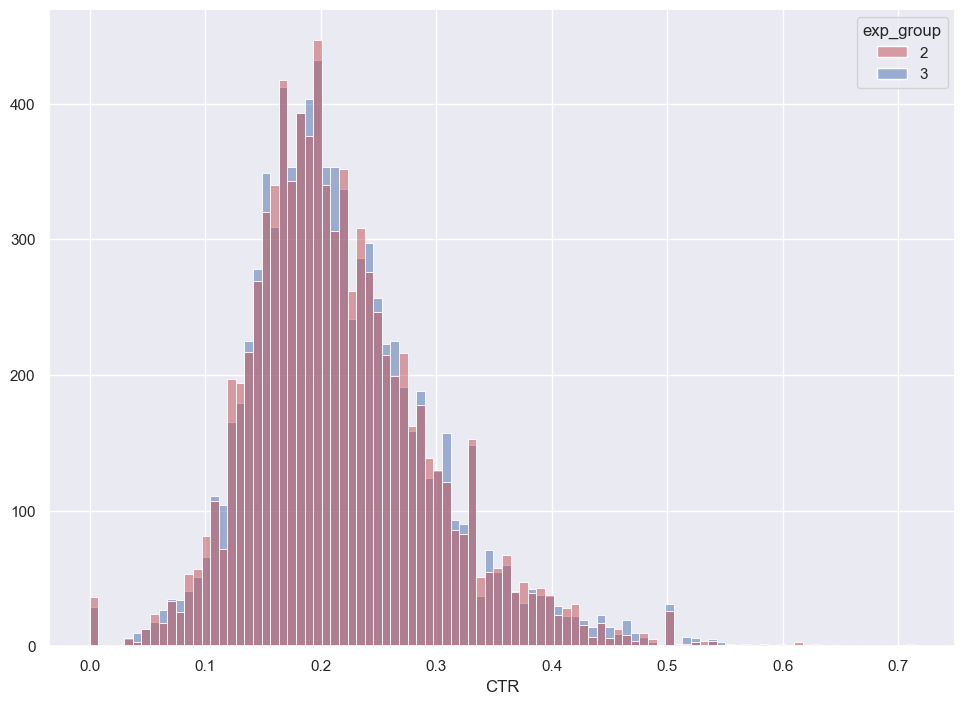

In [19]:
# Нарисуем распределения CTR в группах 2 и 3, чтобы ознакомиться с их формой и визуально оценить,
# насколько метрики в этих группах похожи.

groups = sns.histplot(data = df, 
              x='ctr',
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
groups.set(xlabel='CTR', ylabel='')

In [20]:
def aa_test(group1, group2, iterations=1000, n_users=100):
    assert group1.shape[0] >= n_users and group2.shape[0] >= n_users
    t_test_values = []
    u_test_values = []
    for _ in tqdm(range(iterations)):
        sample1 = group1.sample(n_users, replace=False)
        sample2 = group2.sample(n_users, replace=False)
        ctr1 = sample1.likes / sample1.views
        ctr2 = sample2.likes / sample2.views
        _, pval_t = stats.ttest_ind(ctr1, ctr2, equal_var=False)
        t_test_values.append(pval_t)
        _, pval_u = stats.mannwhitneyu(ctr1, ctr2, alternative='two-sided')
        u_test_values.append(pval_u)
    return t_test_values, u_test_values

In [21]:
# Применим к обеим группам при помощи симуляции многократно как t-тест, так и тест Манна-Уитни,
# с целью сравнения полученных p-value.

t_test_values, u_test_values = aa_test(df[df.exp_group == 2], df[df.exp_group == 3], iterations=10000, n_users=500)

100%|██████████| 10000/10000 [00:22<00:00, 441.75it/s]


[Text(0.5, 0, 'p-values'), Text(0, 0.5, '')]

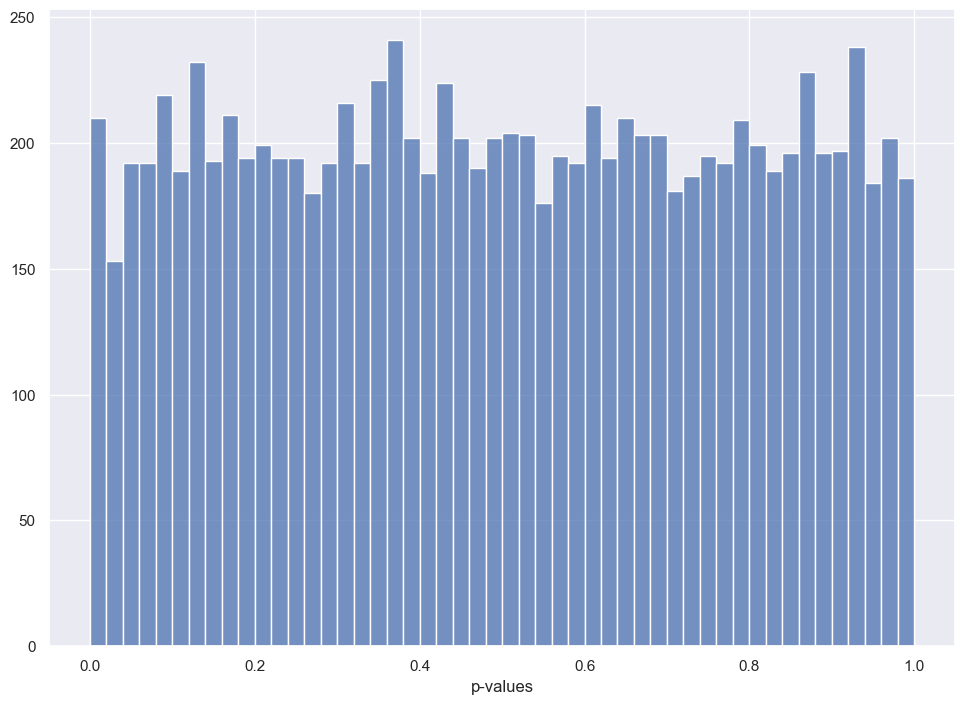

In [22]:
# Построим график распределения p-value, полученных в результате сравнения групп t-тестом.
# Он должен быть похож на равномерное распределение в случае корректного А/А-теста.

ax = sns.histplot(t_test_values, bins=50)
ax.set(xlabel='p-values', ylabel='')

In [23]:
# Посчитаем в скольки процентах случаев мы получим ошибку 1-го рода в результате сравнения групп t-тестом.
# Для 95% интервала это должно быть в менее чем 5% случаев.

counter = 0
for i in t_test_values:
    if i <= 0.05:
        counter += 1
print(counter/len(t_test_values))

0.0459


[Text(0.5, 0, 'p-values'), Text(0, 0.5, '')]

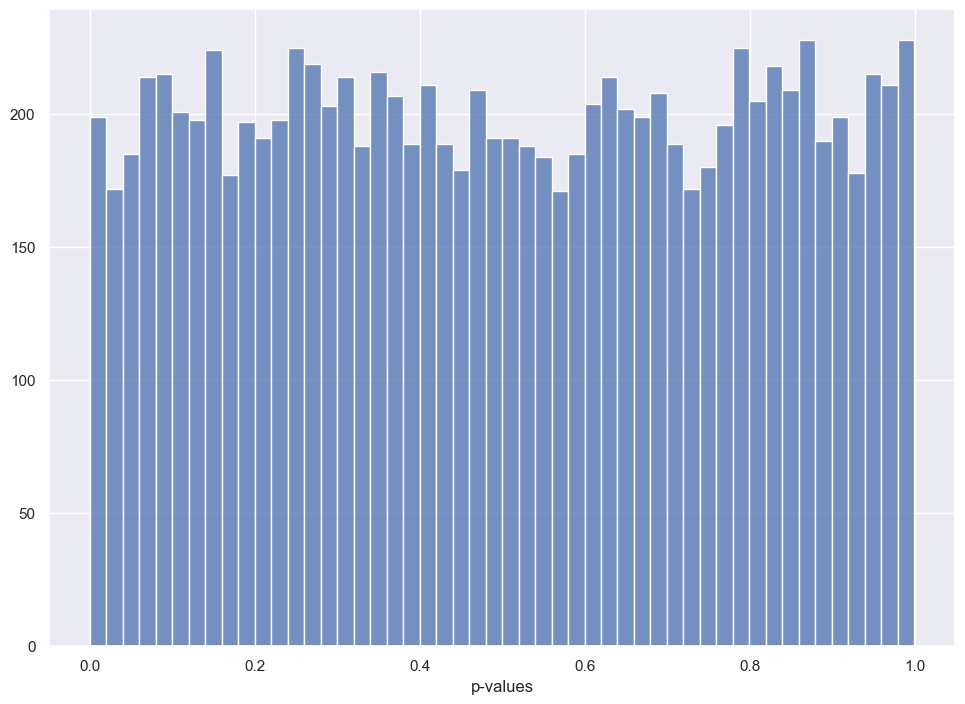

In [24]:
# Построим график распределения p-value, полученных в результате сравнения групп тестом Манна-Уитни.
# Он должен быть похож на равномерное распределение в случае корректного А/А-теста.

ax = sns.histplot(u_test_values, bins=50)
ax.set(xlabel='p-values', ylabel='')

In [25]:
# Посчитаем в скольки процентах случаев мы получим ошибку 1-го рода в результате сравнения групп тестом Манна-Уитни.
# Для 95% интервала это должно быть в менее чем 5% случаев.

counter = 0
for i in u_test_values:
    if i <= 0.05:
        counter += 1
print(counter/len(u_test_values))

0.0458


## На основании проведенного А/А-теста можно сделать вывод о корректности работы используемой системы сплитования, поскольку оба теста (t-тест и тест Манна-Уитни) при проведении 10000 симуляций вернули равномерно распределенные значения p-value, при этом значения p-value ≤ 0.05 появляются в менее чем 5% случаев.